## KNN classifier with feature extraction using MobileNet 

### Reference Links used for code are as given below. 

1. For data pre-processing, splitting into training and validation datasets, feature extraction using a pre-trained CNN model : https://www.kaggle.com/orion99/transfer-learning-cnn?select=seg_test

2. For training a classifier on features extracted : https://appliedmachinelearning.blog/2019/07/29/transfer-learning-using-feature-extraction-from-trained-models-food-images-classification/

3. Original code written for the KNN classifer for training and evaluation and plotting of the metrics

In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
ROOT = '/content/drive'
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
images_dir = 'dataset'
img_width, img_height = 128, 128
batch_size = 32

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import os, shutil
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

In [7]:
train_gen = datagen.flow_from_directory(images_dir, target_size=(img_height, img_width), class_mode='categorical', batch_size=batch_size, subset='training')

Found 7213 images belonging to 16 classes.


In [8]:
test_gen = datagen.flow_from_directory(images_dir, target_size=(img_height, img_width), class_mode='categorical', batch_size=batch_size, subset='validation')

Found 1795 images belonging to 16 classes.


In [9]:
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet', pooling='Max')

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
#Extract features for the training dataset

train_features = np.zeros(shape = (7213,4,4,1280))
train_labels = np.zeros(shape=(7213,16))

i = 0

for inputs_batch, labels_batch in train_gen:
  feature_batch = base_model.predict(inputs_batch)
  train_features[(i*batch_size):((i+1)*batch_size)] = feature_batch
  train_labels[(i*batch_size):((i+1)*batch_size)] = labels_batch
  i = i+1
  if (i*batch_size>=7213):
    break


In [12]:
print(train_features.shape)
print(train_labels.shape)

(7213, 4, 4, 1280)
(7213, 16)


In [13]:
#Extract features for the testing dataset

test_features = np.zeros(shape = (1795,4,4,1280))
test_labels = np.zeros(shape=(1795,16))

i = 0

for inputs_batch, labels_batch in test_gen:
  feature_batch = base_model.predict(inputs_batch)
  test_features[(i*batch_size):((i+1)*batch_size)] = feature_batch
  test_labels[(i*batch_size):((i+1)*batch_size)] = labels_batch
  i = i+1
  if (i*batch_size>=1795):
    break

In [14]:
print(test_features.shape)
print(test_labels.shape)

(1795, 4, 4, 1280)
(1795, 16)


In [17]:
#Flattening the features extraction to train the KNN as it expects array of <= 2 dimensions
train_features_flatten = train_features.reshape((train_features.shape[0], 4 * 4 * 1280))
test_features_flatten = test_features.reshape((test_features.shape[0], 4 * 4 * 1280))

In [18]:
#Training KNN Model for number of neighbors, k = 1,3,5,7,9,11,13
k_range = ([1,3,5,7,9,11,13])
scores_train = []
scores_test = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_features_flatten, train_labels)
  train_labels_pred = knn.predict(train_features_flatten)
  scores_train.append(accuracy_score(train_labels, train_labels_pred))
  test_labels_pred = knn.predict(test_features_flatten)
  scores_test.append(accuracy_score(test_labels, test_labels_pred))

#the below output to be ignored. The correct output is in next cell


Neighbors:  13   Train_Acc_Score:  1.0   Test_Acc_Score:  0.9676880222841225

Neighbors:  13   Train_Acc_Score:  0.9822542631360044   Test_Acc_Score:  0.9632311977715877

Neighbors:  13   Train_Acc_Score:  0.9700540690420075   Test_Acc_Score:  0.9559888579387187

Neighbors:  13   Train_Acc_Score:  0.9604880077637599   Test_Acc_Score:  0.950974930362117

Neighbors:  13   Train_Acc_Score:  0.9538333564397615   Test_Acc_Score:  0.9448467966573816

Neighbors:  13   Train_Acc_Score:  0.947871897962013   Test_Acc_Score:  0.9398328690807799

Neighbors:  13   Train_Acc_Score:  0.9421877166227645   Test_Acc_Score:  0.9376044568245125


IndexError: ignored

In [22]:
for i in range(7):
  print('\nNeighbors: ',k_range[i],'  Train_Acc_Score: ',scores_train[i],'  Test_Acc_Score: ',scores_test[i])



Neighbors:  1   Train_Acc_Score:  1.0   Test_Acc_Score:  0.9676880222841225

Neighbors:  3   Train_Acc_Score:  0.9822542631360044   Test_Acc_Score:  0.9632311977715877

Neighbors:  5   Train_Acc_Score:  0.9700540690420075   Test_Acc_Score:  0.9559888579387187

Neighbors:  7   Train_Acc_Score:  0.9604880077637599   Test_Acc_Score:  0.950974930362117

Neighbors:  9   Train_Acc_Score:  0.9538333564397615   Test_Acc_Score:  0.9448467966573816

Neighbors:  11   Train_Acc_Score:  0.947871897962013   Test_Acc_Score:  0.9398328690807799

Neighbors:  13   Train_Acc_Score:  0.9421877166227645   Test_Acc_Score:  0.9376044568245125


In [23]:
k_range1 = ([15,17,19])


for k in k_range1:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_features_flatten, train_labels)
  train_labels_pred = knn.predict(train_features_flatten)
  scores_train.append(accuracy_score(train_labels, train_labels_pred))
  test_labels_pred = knn.predict(test_features_flatten)
  scores_test.append(accuracy_score(test_labels, test_labels_pred))


In [24]:
for i in range(3):
  print('\nNeighbors: ',k_range1[i],'  Train_Acc_Score: ',scores_train[i],'  Test_Acc_Score: ',scores_test[i])



Neighbors:  15   Train_Acc_Score:  1.0   Test_Acc_Score:  0.9676880222841225

Neighbors:  17   Train_Acc_Score:  0.9822542631360044   Test_Acc_Score:  0.9632311977715877

Neighbors:  19   Train_Acc_Score:  0.9700540690420075   Test_Acc_Score:  0.9559888579387187


In [28]:
range = k_range + k_range1
np.array(range)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

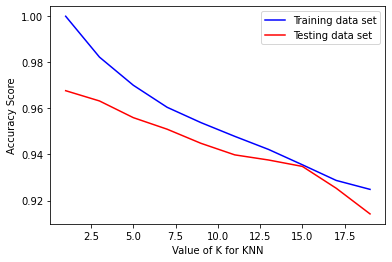

In [29]:
plt.plot(range,scores_train,'b-',range,scores_test,'r-')
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Testing data set",))
plt.show()

In [33]:
#We select a value of K between 1 and 19 as this range of numbers has the highest accuracy scores
#Consider k = 15 and train the model again

knn1 = KNeighborsClassifier(n_neighbors = 15)
knn1.fit(train_features_flatten, train_labels)
test_labels_pred = knn1.predict(test_features_flatten)

In [51]:
print("\n\nClassification Report on Testing Data:\n\n",classification_report(test_labels, test_labels_pred))

print("\n\nAccuracy Score on Testing Data: ", accuracy_score(test_labels, test_labels_pred))



Classification Report on Testing Data:

               precision    recall  f1-score   support

           0       0.98      0.96      0.97       119
           1       0.99      0.96      0.97       112
           2       0.97      0.85      0.91        86
           3       0.94      0.88      0.91       108
           4       1.00      0.85      0.92       105
           5       1.00      0.85      0.92        86
           6       0.97      0.97      0.97       116
           7       0.93      0.93      0.93       106
           8       0.99      0.91      0.95       110
           9       0.97      0.85      0.91       109
          10       0.97      0.97      0.97       119
          11       1.00      0.99      1.00       124
          12       0.99      0.96      0.98       123
          13       0.98      0.97      0.97       126
          14       0.98      1.00      0.99       115
          15       0.98      0.98      0.98       131

   micro avg       0.98      0.93    

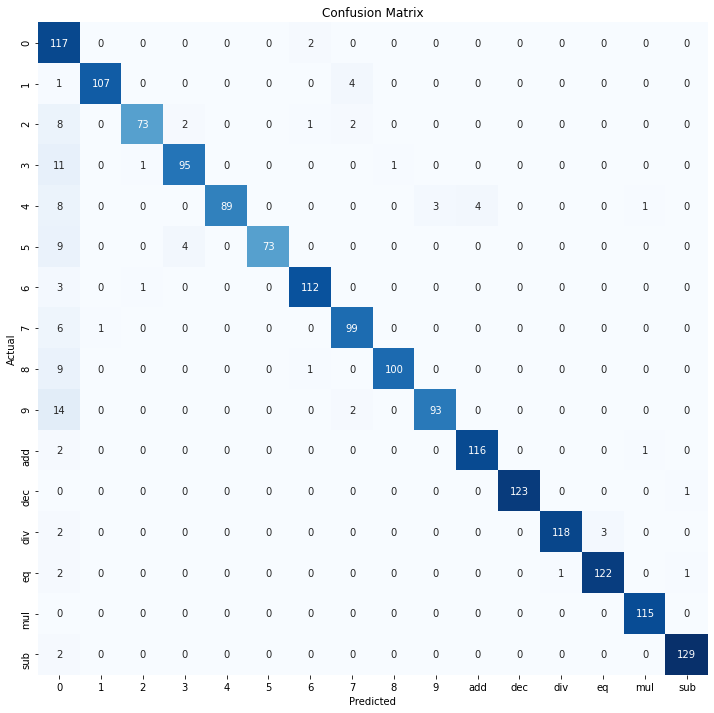

In [47]:
classes = list(test_gen.class_indices.keys())

cm = confusion_matrix(test_labels.argmax(axis=1), test_labels_pred.argmax(axis=1), )
plt.figure(figsize=(12, 12))
sns.heatmap(cm, xticklabels = classes , yticklabels = classes, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()